# Bayesian Gaussian Mixture Modeling using TensorFlow Probability

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  # prevent tensorflow from using GPU

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
# TensorFlow 2 enables eager execution by default
# tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.1.0-dev20191015
TensorFlow Probability version: 0.9.0-dev20191016


## Generate some data

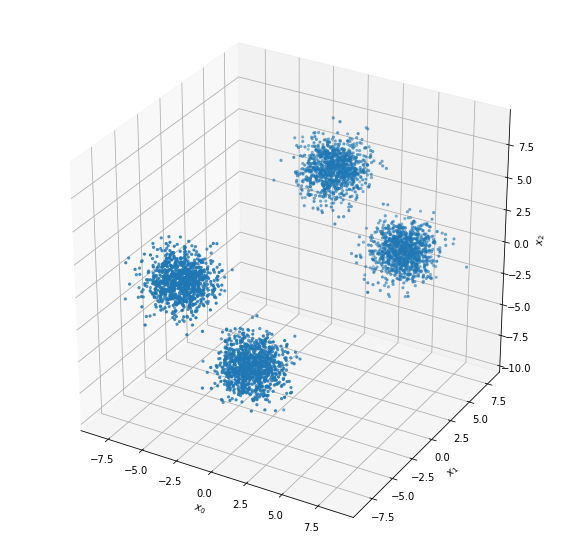

In [2]:
eps = 1e-3
n_samples_per_component = 1000
n_dims = 3
n_components = 4
n_samples = n_samples_per_component * n_components

X = np.random.randn(n_samples, n_dims).astype('float32')  # assume identity covariance matrix

X[:n_samples_per_component, :] += [5, 5, 0]
X[n_samples_per_component:2 * n_samples_per_component, :] += [-5, -5, 0]
X[2 * n_samples_per_component:3 * n_samples_per_component, :] += [0, 5, 5]
X[3 * n_samples_per_component:, :] += [0, -5, -5]

# Plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
plt.show()

## Make a TensorFlow Dataset from that data

In [3]:
batch_size = 2000
dataset = tf.data.Dataset.from_tensor_slices((X)).shuffle(10000).batch(batch_size)

## Build a Gaussian Mixture Model via model subclassing

In [4]:
class GaussianMixtureModel(tf.keras.Model):
    """A Bayesian Gaussian mixture model.
    
    Assumes Gaussians' variances in each dimension are independent.
    
    Parameters
    ----------
    n_components : int > 0
        Number of mixture components.
    n_dims : int > 0
        Number of dimensions.
    """
    def __init__(self, n_components, n_dims):
        # Initialize
        super(GaussianMixtureModel, self).__init__()
        self.n_components = n_components
        self.n_dims = n_dims
        
        # Variational posterior distribution variables for variances
        self.alpha = tf.Variable(0.5 * tf.ones((n_components, n_dims)), name='alpha',
                                 constraint=lambda x: tf.clip_by_value(x, eps, np.infty))  # non-negative
        self.beta = tf.Variable(0.5 * tf.ones((n_components, n_dims)), name='beta',
                                constraint=lambda x: tf.clip_by_value(x, eps, np.infty))  # non-negative
        
        # Variational posterior distribution variables for means
        self.mu0 = tf.Variable(tf.zeros((n_components, n_dims)), name='mu0')
        self.v = tf.Variable(tf.ones((n_components, n_dims)), name='v',
                             constraint=lambda x: tf.clip_by_value(x, eps, np.infty))  # non-negative
        
        # Variational posterior distribution variables for component weights
        self.counts = tf.Variable(2 * tf.ones((n_components,)), name='counts',
                                  constraint=lambda x: tf.clip_by_value(x, eps, np.infty))  # non-negative

        # Prior distributions for the inverse variances
        self.invvar_prior = tfd.Gamma(concentration=0.5 * tf.ones((n_components, n_dims)),
                                      rate=0.5 * tf.ones((n_components, n_dims)),
                                      validate_args=True, allow_nan_stats=False)
        
        # Prior distributions for the means
        self.mu_prior = tfd.Normal(loc=tf.zeros((n_components, n_dims)),
                                   scale=1 / tf.sqrt(self.invvar_prior.sample(1)[0]),
                                   validate_args=True, allow_nan_stats=False)
        
        # Prior distributions for the component weights
        self.theta_prior = tfd.Dirichlet(concentration=2 * tf.ones((n_components,)),
                                         validate_args=True, allow_nan_stats=False)
        
    def call(self, x, sampling=True):
        """Compute losses given a batch of data.
        
        Parameters
        ----------
        x : tf.Tensor
            A batch of data
        sampling : bool
            Whether to sample from the variational posterior
            distributions (if True, the default), or just use the
            mean of the variational distributions (if False).
            
        Returns
        -------
        log_likelihoods : tf.Tensor
            Log likelihood for each sample
        kl_sum : tf.Tensor
            Sum of the KL divergences between the variational
            distributions and their priors
        """
        
        # The variational distributions
        invvar = tfd.Gamma(concentration=self.alpha,
                           rate=self.beta,
                           validate_args=True, allow_nan_stats=False)  # sigma^{-2}
        mu_var = self.v / invvar.sample(1)[0]
        mu = tfd.Normal(loc=self.mu0,
                        scale=tf.sqrt(mu_var),
                        validate_args=True, allow_nan_stats=False)
        theta = tfd.Dirichlet(concentration=self.counts,
                              validate_args=True, allow_nan_stats=False)
        
        # Sample from the variational distributions
        if sampling:
            batch_size = x.shape[0] # number of samples in the batch
            mu_sample = mu.sample(batch_size)
            sigma_sample = 1 / tf.sqrt(invvar.sample(batch_size))
            theta_sample = theta.sample(batch_size)
        else:
            mu_sample = tf.reshape(mu.mean(), (1, self.n_components, self.n_dims))
            sigma_sample = 1 / tf.sqrt(tf.reshape(invvar.mean(), (1, self.n_components, self.n_dims)))
            theta_sample = tf.reshape(theta.mean(), (1, self.n_components))
        
        # The Gaussian mixture model distribution
        gmm = tfd.Mixture(cat=tfd.Categorical(probs=theta_sample),
                              components=[tfd.MultivariateNormalDiag(loc=mu_sample[:, i],
                                                                     scale_diag=sigma_sample[:, i]) 
                                          for i in range(self.n_components)])
                
        # Compute the mean log likelihood
        log_likelihoods = gmm.log_prob(x)
        
        # Compute the KL divergence sum
        div_invvar = tfd.kl_divergence(invvar, self.invvar_prior)
        div_mu = tfd.kl_divergence(mu, self.mu_prior)
        div_theta = tfd.kl_divergence(theta, self.theta_prior)
        kl_sum = div_invvar + div_mu + div_theta
        
        # Return both losses
        return log_likelihoods, kl_sum
    
# model instantiation
model = GaussianMixtureModel(n_components, n_dims)

## Model fitting

In [5]:
lr = 2e-3
optimizer = tf.keras.optimizers.Adam(lr=lr)

loss_nll = tf.keras.metrics.Mean(name='negative_log_likelihoods')
loss_kl = tf.keras.metrics.Mean(name='KL_divergence')
loss_train = tf.keras.metrics.Mean(name='loss_train')

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        log_likelihoods, kl_sum = model(data)
        neg_elbo = tf.reduce_mean(kl_sum/n_samples) - tf.reduce_mean(log_likelihoods)
    tvars = model.trainable_variables
    gradients = tape.gradient(neg_elbo, tvars)
    optimizer.apply_gradients(zip(gradients, tvars))
    # record metrics
    loss_nll(-tf.reduce_mean(log_likelihoods))
    loss_kl(tf.reduce_mean(kl_sum/n_samples))
    loss_train(neg_elbo)
    
# Fit the model
n_epochs = 10000
n_epochs_per_print = 100
for epoch in range(n_epochs):
    for data in dataset:
        train_step(data)
    if (epoch + 1) % n_epochs_per_print == 0:
        print('Epoch {}: nll = {:.4f}, kl = {:.4f}, -elbo = {:.4f}'.format(epoch+1,
                                                                           loss_nll.result(),
                                                                           loss_kl.result(),
                                                                           loss_train.result()))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`AffineLinearOperator` bijector is deprecated; please use `tfb.Shift(loc)(tfb.MatvecLinearOperator(...))`.
Epoch 100: nll = 14.2117, kl = 13.1769, -elbo = 27.3886
Epoch 200: nll = 13.7023, kl = 8.3260, -elbo = 22.0282
Epoch 300: nll = 13.4169, kl = 5.5920, -elbo = 19.0090
Epoch 400: nll = 13.1025, kl = 4.2206, -elbo = 17.3232
Epoch 500: nll = 12.7972, kl = 3.5037, -elbo = 16.3009
Epoch 600: nll = 12.5782, kl = 4.9830, -elbo = 17.5611
Epoch 700: nll = 12.3573, kl = 4.3214, -elbo = 16.6787
Epoch 800: nll = 12.1524, kl = 4.3779, -elbo = 16.5303
Epoch 900: nll = 11.9474, kl = 3.9014, -elbo = 15.8489
Epoch 1000: nll = 11.7752, kl = 3.5224, -elbo = 15.2977
Epoch 1100: nll = 11.6062, kl = 3.2984, -elbo = 14.9046
Epoch 1200: nll = 11.4389, kl = 3.0273, -elbo = 14.4661
Epoch 1300: nll = 11.2778, kl = 2.7955, -elbo = 14.0733
Epoch 1400: nll = 11.1229, kl = 2.5971, -elbo = 13.7199
Epo

## Plot log-likelihood (sliced on the $x_2$ axis)

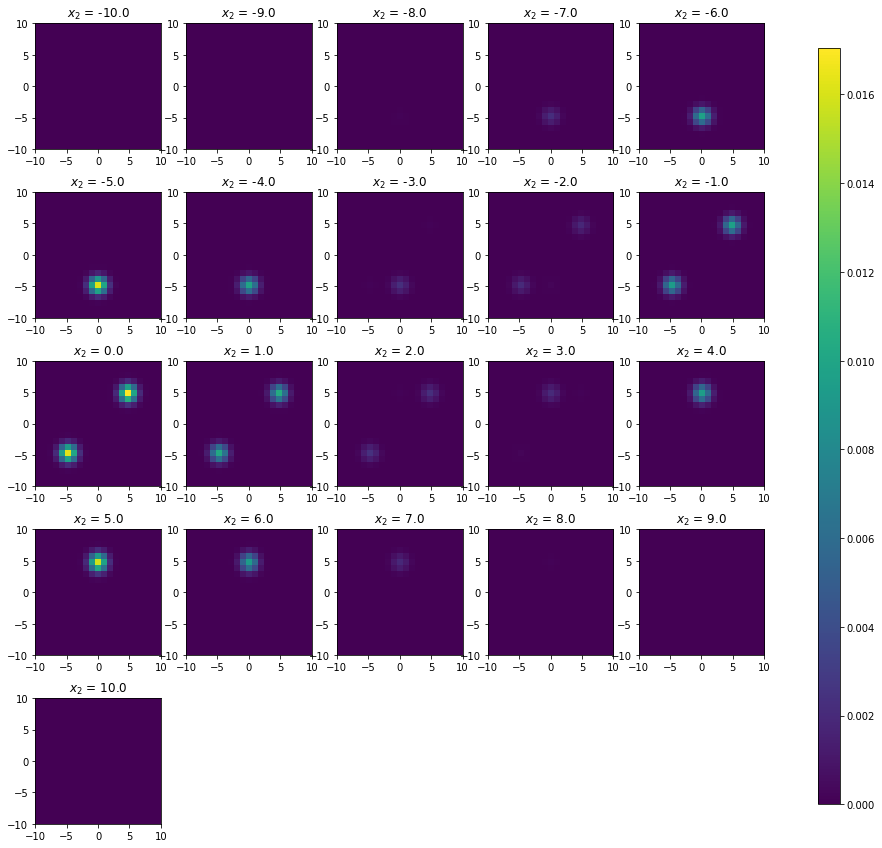

In [6]:
# Compute log likelihood at each point on a grid
n_grids = 21 # number of grid points
x0_, x1_, x2_ = np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids), np.linspace(-10, 10, n_grids)
x0_grid, x1_grid, x2_grid = np.meshgrid(x0_, x1_, x2_)
grids = np.column_stack([x0_grid.flatten(), x1_grid.flatten(), x2_grid.flatten()])
ll, _ = model(grids.astype('float32'), sampling=False)
ll = np.reshape(ll, (n_grids, n_grids, n_grids))
        
# Show the fit loglikelihood (slices of x2-axis)
n_subplot_rows = 5
fig, ax = plt.subplots(n_subplot_rows, n_grids // n_subplot_rows + 1, figsize=(15, 15))
for i in range(n_subplot_rows):
    for j in range(n_grids // n_subplot_rows + 1):
        idx = i * (n_grids // n_subplot_rows + 1) + j
        if idx < n_grids:
            im = ax[i, j].imshow(np.exp(ll)[:, :, idx], extent=(-10, 10, -10, 10), origin='lower',
                                 vmin=0, vmax=np.exp(ll).max())
            ax[i, j].title.set_text('$x_2$ = {}'.format(x2_[idx]))
        else:
            ax[i, j].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Output trainable variables

In [7]:
{v.name: v.numpy() for v in model.trainable_variables}

{'alpha:0': array([[ 7.7017894,  2.6322243,  7.6739717],
        [ 5.6613173,  3.2694697, 10.349461 ],
        [ 3.1179545, 10.168952 ,  9.409083 ],
        [ 1.538792 ,  9.951087 ,  9.890806 ]], dtype=float32),
 'beta:0': array([[ 7.1398454,  2.5734344,  7.311108 ],
        [ 5.6047544,  3.1350083, 10.356618 ],
        [ 3.2042124,  9.436888 ,  9.603993 ],
        [ 1.5228442, 10.405263 ,  9.61159  ]], dtype=float32),
 'mu0:0': array([[ 5.0068846 ,  4.956473  ,  0.03962005],
        [-4.971788  , -5.017012  ,  0.04320389],
        [ 0.01405289, -5.042717  , -4.9906178 ],
        [ 0.02691171,  4.954774  ,  4.9922805 ]], dtype=float32),
 'v:0': array([[0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001]], dtype=float32),
 'counts:0': array([18.214891, 18.216925, 18.250193, 18.220451], dtype=float32)}

## Pairwise plot

Mean of standard deviations (for each component):
[array([1.0128965, 1.1593451, 1.0281819], dtype=float32), array([1.0697461, 1.1133785, 1.0397857], dtype=float32), array([1.1595819, 1.0028763, 1.0506697], dtype=float32), array([1.3641955, 1.0656922, 1.0246829], dtype=float32)]
Mean of mus (for each component):
[array([5.006824  , 4.9571834 , 0.03955845], dtype=float32), array([-4.971923  , -5.0166273 ,  0.04300141], dtype=float32), array([ 0.01378512, -5.042443  , -4.9910793 ], dtype=float32), array([0.02771061, 4.9550686 , 4.993084  ], dtype=float32)]


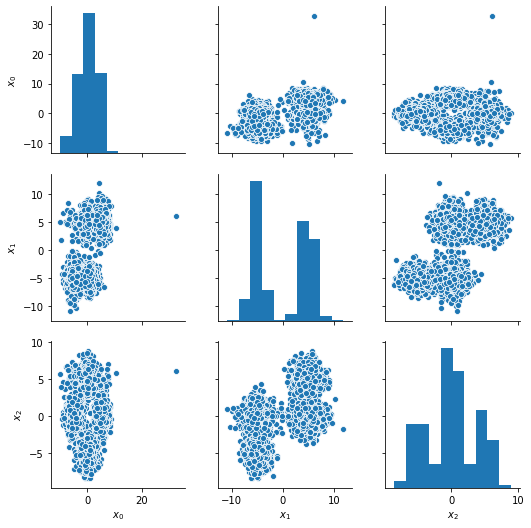

In [8]:
test_size = 10000

# sample sigma
invvar = tfd.Gamma(concentration=model.alpha,
                   rate=model.beta,
                   validate_args=True, allow_nan_stats=False)  # sigma^{-2}
sigma_sample = 1 / tf.sqrt(invvar.sample(test_size))
print('Mean of standard deviations (for each component):\n{}'.format(
    [tf.reduce_mean(sigma_sample[:, i], axis=0).numpy() for i in range(model.n_components)]))

# sample mu
mu_var = model.v / invvar.sample(1)[0]
mu = tfd.Normal(loc=model.mu0,
                scale=tf.sqrt(mu_var),
                validate_args=True, allow_nan_stats=False)
mu_sample = mu.sample(test_size)
print('Mean of mus (for each component):\n{}'.format(
    [tf.reduce_mean(mu_sample[:, i], axis=0).numpy() for i in range(model.n_components)]))

# sample theta
theta = tfd.Dirichlet(concentration=model.counts,
                      validate_args=True, allow_nan_stats=False)
theta_sample = theta.sample(test_size)

# build Gaussian mixture model and sample
gmm = tfd.Mixture(cat=tfd.Categorical(probs=theta_sample),
                  components=[tfd.MultivariateNormalDiag(loc=mu_sample[:, i],
                                                         scale_diag=sigma_sample[:, i]) 
                              for i in range(model.n_components)])
gmm_sample = gmm.sample(1)[0]

# build dataset
dataset = pd.DataFrame({'$x_0$': gmm_sample[:, 0],
                        '$x_1$': gmm_sample[:, 1],
                        '$x_2$': gmm_sample[:, 2]})
fig_sns = sns.pairplot(dataset)